# LOAD PACKAGES

In [38]:
# basic tools
import os
import pandas as pd
import numpy as np

# image preprocessing
import cv2

# tensorflow tools
import tensorflow as tf

# image processsing
from tensorflow.keras.preprocessing.image import (load_img,
                                                  img_to_array,
                                                  ImageDataGenerator)
# VGG16 model
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)

# layers
from tensorflow.keras.layers import (Flatten, 
                                     Dense, 
                                     Dropout, 
                                     BatchNormalization)
# generic model object
from tensorflow.keras.models import Model

# optimizers
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD

#scikit-learn
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report

# for plotting
import matplotlib.pyplot as plt

# FUNCTIONS

In [39]:
# courtesy of Ross
def plot_history(H, epochs):
    plt.style.use("seaborn-colorblind")

    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    plt.plot(
        np.arange(0, epochs), 
        H.history["loss"], 
        label = "train_loss")
    plt.plot(
        np.arange(0, epochs), 
        H.history["val_loss"], 
        label = "val_loss", 
        linestyle = ":")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(
        np.arange(0, epochs), 
        H.history["accuracy"], 
        label = "train_acc")
    plt.plot(
        np.arange(0, epochs), 
        H.history["val_accuracy"], 
        label = "val_acc", 
        linestyle = ":")
    plt.title("Accuracy curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend()

    plt.show()

# CONFIGURE DIRECTORIES

In [40]:
# OVERALL LOCATION OF DATA
base_dir = os.path.join(
    "..",
    "..",
    "data")

# LOCATION OF TEST, TRAIN AND VALIDATION FOLDERS
train_dir = os.path.join(
    base_dir,
    "train")
val_dir = os.path.join(
    base_dir,
    "val")
test_dir = os.path.join(
    base_dir,
    "test")

# LOCATION OF CATEGORIES WITHIN TRAIN SPLIT
train_coast_dir = os.path.join(
    train_dir,
    "Coast")
train_desert_dir = os.path.join(
    train_dir,
    "Desert")
train_forest_dir = os.path.join(
    train_dir,
    "Forest")
train_glacier_dir = os.path.join(
    train_dir,
    "Glacier")
train_mountain_dir = os.path.join(
    train_dir,
    "Mountain")

# LOCATION OF CATEGORIES WITHIN VALIDATION SPLIT
val_coast_dir = os.path.join(
    val_dir,
    "Coast")
val_desert_dir = os.path.join(
    val_dir,
    "Desert")
val_forest_dir = os.path.join(
    val_dir,
    "Forest")
val_glacier_dir = os.path.join(
    val_dir,
    "Glacier")
val_mountain_dir = os.path.join(
    val_dir,
    "Mountain")

# LOCATION OF CATEGORIES WITHIN TEST SPLIT
test_coast_dir = os.path.join(
    test_dir,
    "Coast")
test_desert_dir = os.path.join(
    test_dir,
    "Desert")
test_forest_dir = os.path.join(
    test_dir,
    "Forest")
test_glacier_dir = os.path.join(
    test_dir,
    "Glacier")
test_mountain_dir = os.path.join(
    test_dir,
    "Mountain")

# COUNT NUMBER OF IMAGES

In [41]:
# IMAGES IN CATEGORIES IN TRAINING SPLIT
num_train_coast = len(
    os.listdir(
        train_coast_dir))
num_train_desert = len(
    os.listdir(
        train_desert_dir))
num_train_forest = len(
    os.listdir(
        train_forest_dir))
num_train_glacier = len(
    os.listdir(
        train_glacier_dir))
num_train_mountain = len(
    os.listdir(
        train_mountain_dir))

# IMAGES IN CATEGORIES IN VALIDATION SPLIT
num_val_coast = len(
    os.listdir(
        val_coast_dir))
num_val_desert = len(
    os.listdir(
        val_desert_dir))
num_val_forest = len(
    os.listdir(
        val_forest_dir))
num_val_glacier = len(
    os.listdir(
        val_glacier_dir))
num_val_mountain = len(
    os.listdir(
        val_mountain_dir))

# IMAGES IN CATEGORIES IN TEST SPLIT
num_test_coast = len(
    os.listdir(
        test_coast_dir))
num_test_desert = len(
    os.listdir(
        test_desert_dir))
num_test_forest = len(
    os.listdir(
        test_forest_dir))
num_test_glacier = len(
    os.listdir(
        test_glacier_dir))
num_test_mountain = len(
    os.listdir(
        test_mountain_dir))

num_train = num_train_coast + num_train_desert + num_train_forest + num_train_glacier + num_train_mountain
num_val = num_val_coast + num_val_desert + num_val_forest + num_val_glacier + num_val_mountain
num_test = num_test_coast + num_test_desert + num_test_forest + num_test_glacier + num_test_mountain

num_total = num_train + num_val + num_test

In [42]:
print("TOTAL IMAGES:", num_total)
print("...")
print("TOTAL TRAIN:", num_train)
print("Coast:", num_train_coast)
print("Desert:", num_train_desert)
print("Forest:", num_train_forest)
print("Glacier:", num_train_glacier)
print("Mountain:", num_train_mountain)
print("...")
print("TOTAL VALIDATION:", num_val)
print("Coast:", num_val_coast)
print("Desert:", num_val_desert)
print("Forest:", num_val_forest)
print("Glacier:", num_val_glacier)
print("Mountain:", num_val_mountain)
print("...")
print("TOTAL TEST:", num_test)
print("Coast:", num_test_coast)
print("Desert:", num_test_desert)
print("Forest:", num_test_forest)
print("Glacier:", num_test_glacier)
print("Mountain:", num_test_mountain)


TOTAL IMAGES: 12000
...
TOTAL TRAIN: 10000
Coast: 2000
Desert: 2000
Forest: 2000
Glacier: 2000
Mountain: 2000
...
TOTAL VALIDATION: 1500
Coast: 300
Desert: 300
Forest: 300
Glacier: 300
Mountain: 300
...
TOTAL TEST: 500
Coast: 100
Desert: 100
Forest: 100
Glacier: 100
Mountain: 100


# IMAGE PREPROCESSING

In [43]:
# SOME NECESSARY VARIABLES
IMG_SHAPE = 224
batch_size = 128

In [44]:
# DEFINE DATA GENERATOR
# Normalize image values.
# Allow for horizontal flipping and rotation (data augmentation).
datagen = ImageDataGenerator(
    rescale = 1./255, 
    horizontal_flip = True, 
    rotation_range = 20,
    preprocessing_function = lambda x: tf.image.resize(
        x, 
        (IMG_SHAPE, IMG_SHAPE)))

In [45]:
# TRAINING - FLOW FROM FOLDER
train_data_gen = datagen.flow_from_directory(
    directory = train_dir,
    batch_size = batch_size,
    target_size = (IMG_SHAPE, IMG_SHAPE),
    shuffle = True,
    class_mode = 'categorical')

Found 10000 images belonging to 5 classes.


In [46]:
# VALIDATION - FLOW FROM FOLDER
val_data_gen = datagen.flow_from_directory(
    directory = val_dir,
    batch_size = batch_size,
    target_size = (IMG_SHAPE, IMG_SHAPE),
    shuffle = True,
    class_mode = 'categorical')

Found 1500 images belonging to 5 classes.


In [61]:
# TEST - FLOW FROM FOLDER
test_data_gen = datagen.flow_from_directory(
    directory = test_dir,
    batch_size = batch_size,
    target_size = (IMG_SHAPE, IMG_SHAPE),
    shuffle = False,
    class_mode = 'categorical')

Found 500 images belonging to 5 classes.


# LOAD MODEL

In [48]:
# load model without classifier layers
model = VGG16(
    include_top = False, 
    pooling = 'avg',
    input_shape = (224, 224, 3))

In [49]:
# mark loaded layers as not trainable
for layer in model.layers:
    layer.trainable = False

In [50]:
# add new classifier layers
flat1 = Flatten()(model.layers[-1].output)
bn = BatchNormalization()(flat1)
class1 = Dense(
    256, 
    activation = 'relu')(bn)
class2 = Dense(
    128, 
    activation = 'relu')(class1)
output = Dense(
    5, 
    activation = 'softmax')(class2)

In [51]:
# define new model
model = Model(
    inputs = model.inputs, 
    outputs = output)

In [52]:
# configure learning rate
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate = 0.01,
    decay_steps = 10000,
    decay_rate = 0.9)
sgd = SGD(learning_rate = lr_schedule)

In [53]:
# compile model
model.compile(
    optimizer = sgd,
    loss = 'categorical_crossentropy',
    metrics = ['accuracy'])

In [54]:
# summarize
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [55]:
H = model.fit(
    train_data_gen,
    validation_data = val_data_gen,
    epochs = 10)

Epoch 1/10


2023-05-01 17:16:21.646626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


79/79 [==============================] - ETA: 0s - loss: 1.3559 - accuracy: 0.4403

2023-05-01 17:28:04.010229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


79/79 [==============================] - 807s 10s/step - loss: 1.3559 - accuracy: 0.4403 - val_loss: 1.5235 - val_accuracy: 0.3020
Epoch 2/10
79/79 [==============================] - 363s 5s/step - loss: 1.0786 - accuracy: 0.5921 - val_loss: 1.3755 - val_accuracy: 0.4673
Epoch 3/10
79/79 [==============================] - 365s 5s/step - loss: 0.9696 - accuracy: 0.6356 - val_loss: 1.2130 - val_accuracy: 0.5953
Epoch 4/10
79/79 [==============================] - 408s 5s/step - loss: 0.8977 - accuracy: 0.6693 - val_loss: 1.0897 - val_accuracy: 0.6167
Epoch 5/10
79/79 [==============================] - 728s 9s/step - loss: 0.8466 - accuracy: 0.6900 - val_loss: 1.0144 - val_accuracy: 0.6273
Epoch 6/10
79/79 [==============================] - 359s 5s/step - loss: 0.8099 - accuracy: 0.7071 - val_loss: 0.9423 - val_accuracy: 0.6553
Epoch 7/10
79/79 [==============================] - 359s 5s/step - loss: 0.7713 - accuracy: 0.7177 - val_loss: 0.9143 - val_accuracy: 0.6587
Epoch 8/10
79/79 [=====

/tmp/ipykernel_1543/3076450021.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-colorblind")


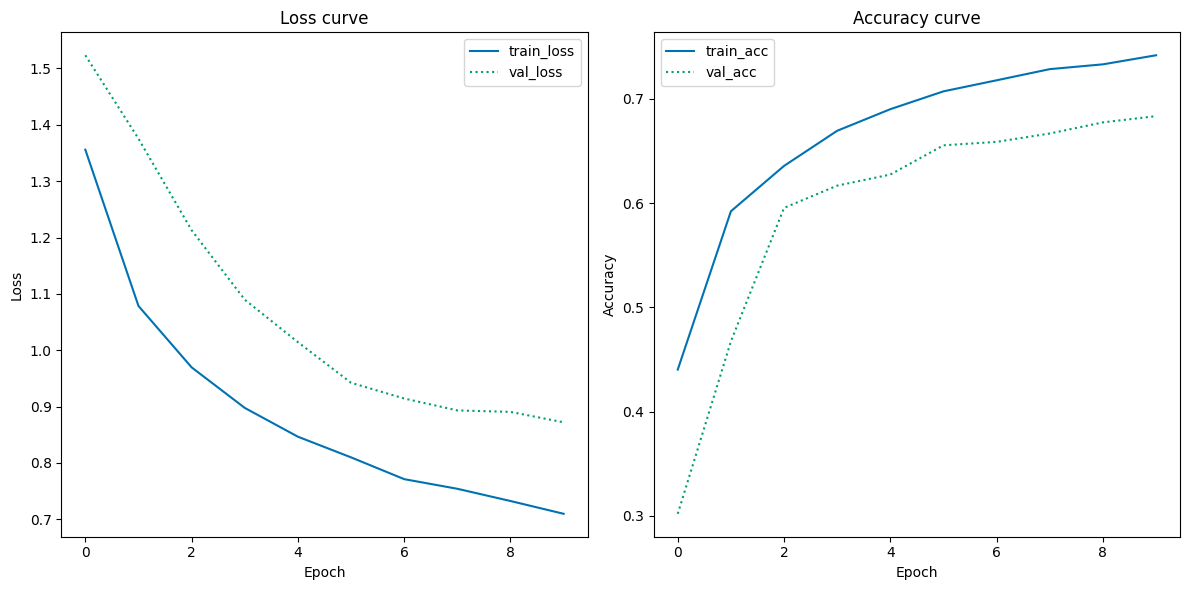

In [56]:
plot = plot_history(H, 10)

In [62]:
predictions = model.predict(
    test_data_gen, 
    batch_size = batch_size)

2023-05-01 18:43:21.660730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


4/4 [==============================] - 16s 4s/step


In [63]:
y_true = test_data_gen.classes

In [66]:
y_pred = np.argmax(predictions, axis = 1)

In [67]:
class_labels = list(test_data_gen.class_indices.keys())

In [68]:
report = classification_report(
    y_true, 
    y_pred, 
    target_names = class_labels)

In [70]:
print(report)

              precision    recall  f1-score   support

       Coast       0.76      0.73      0.74       100
      Desert       0.79      0.81      0.80       100
      Forest       0.88      0.85      0.86       100
     Glacier       0.69      0.81      0.74       100
    Mountain       0.60      0.52      0.56       100

    accuracy                           0.74       500
   macro avg       0.74      0.74      0.74       500
weighted avg       0.74      0.74      0.74       500

